In [1]:
import numpy as np
import struct,os
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
import torch

def load_mnist(image_file, label_file):
    digits=np.arange(10)

    fname_image = os.path.join("../"+image_file)
    fname_label = os.path.join("../"+label_file)

    flbl = open(fname_label, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_image, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows*cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((1, rows*cols))
        labels[i] = lbl[ind[i]]

    return images, labels

train_image, train_label = load_mnist("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_image, test_label = load_mnist("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device ='cpu'
layers=4
lsize=[train_image.shape[1],17*17,16*16,15*15,10]

W=[(torch.randn(lsize[i],lsize[i+1],dtype=torch.float32)*(1/lsize[i])).to(device) for i in range(layers)]
b=[torch.randn(lsize[i],dtype=torch.float32).to(device) for i in range(1,layers+1)]

ty=torch.zeros([train_image.shape[0],lsize[len(lsize)-1]],dtype=torch.float32).to(device)
for i in range(train_image.shape[0]):
    ty[i][train_label[i].item()]=1.0

In [3]:
print("W's shape is")
for i in range(len(W)):
    print(W[i].shape)
print("b's shape is")
for i in range(len(b)):
    print(b[i].shape)

W's shape is
torch.Size([784, 289])
torch.Size([289, 256])
torch.Size([256, 225])
torch.Size([225, 10])
b's shape is
torch.Size([289])
torch.Size([256])
torch.Size([225])
torch.Size([10])


In [4]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_image=torch.from_numpy(train_image).float().to(device)
train_label=torch.from_numpy(train_label).int().to(device)
test_image=torch.from_numpy(test_image).float().to(device)
test_label=torch.from_numpy(test_label).int().to(device)

In [5]:
m = torch.nn.Sigmoid()
rl=torch.nn.ReLU()
A=[]
def predict(img):
    A.clear()
    A.append(rl(img@W[0]+b[0]))
    for i in range(layers-2):
        A.append(rl(A[i]@W[i+1]+b[i+1]))
    A.append(m(A[layers-2]@W[layers-1]+b[layers-1]))
    return A[len(A)-1]
predict(test_image)

tensor([[0.6826, 0.5316, 0.4798,  ..., 0.3156, 0.5603, 0.2058],
        [0.6827, 0.5315, 0.4799,  ..., 0.3156, 0.5604, 0.2057],
        [0.6827, 0.5316, 0.4799,  ..., 0.3156, 0.5604, 0.2057],
        ...,
        [0.6827, 0.5316, 0.4799,  ..., 0.3156, 0.5604, 0.2058],
        [0.6827, 0.5316, 0.4799,  ..., 0.3156, 0.5604, 0.2057],
        [0.6826, 0.5317, 0.4798,  ..., 0.3155, 0.5603, 0.2057]],
       device='cuda:0')

In [35]:
predict(test_image)[:3]

tensor([[8.9553e-25, 0.0000e+00, 3.6146e-18, 1.8935e-11, 1.6281e-12, 1.9617e-18,
         3.5752e-29, 1.0000e+00, 1.2159e-12, 7.1201e-12],
        [4.4209e-18, 5.9098e-26, 1.0000e+00, 8.3087e-08, 0.0000e+00, 1.2415e-09,
         3.1473e-13, 0.0000e+00, 3.1480e-16, 0.0000e+00],
        [1.7547e-09, 9.9996e-01, 8.9201e-03, 1.6902e-08, 6.9905e-09, 2.9816e-05,
         2.5733e-11, 1.2595e-06, 5.7637e-08, 3.5061e-04]], device='cuda:0')

In [66]:
predict(test_image)[:3]

tensor([[0.1535, 0.1601, 0.1432, 0.1686, 0.1405, 0.1520, 0.1439, 0.1332, 0.1532,
         0.1540],
        [0.1516, 0.1584, 0.1424, 0.1653, 0.1397, 0.1497, 0.1432, 0.1328, 0.1512,
         0.1521],
        [0.1577, 0.1640, 0.1453, 0.1764, 0.1422, 0.1573, 0.1457, 0.1340, 0.1581,
         0.1584]], device='cuda:0')

In [63]:
print(ty[:3])

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')


In [8]:
print("A's shape is")
for i in range(len(A)):
    print(A[i].shape)

A's shape is
torch.Size([60000, 289])
torch.Size([60000, 256])
torch.Size([60000, 225])
torch.Size([60000, 10])


In [33]:
def train_accu():
    err=0
    Y=torch.argmax(predict(train_image),dim=1)
    for i in range(Y.shape[0]):
        if(Y[i]!=train_label[i]):
            err+=1
    return (1-err/train_image.shape[0])
print("%.10lf"%train_accu())

0.9700666667


In [32]:
def genaralization_accu():
    err=0
    Y=torch.argmax(predict(test_image),dim=1)
    for i in range(Y.shape[0]):
        if(Y[i]!=test_label[i]):
            err+=1
    return (1-err/test_image.shape[0])
print("%.10lf"%genaralization_accu())

0.9446000000


In [28]:
def loss():
    tmp=(predict(train_image)-ty)
    # print((tmp*tmp).shape)
    return (tmp*tmp).sum().item()
print(loss())

3085.487548828125


In [41]:
torch.set_printoptions(precision=10)

In [19]:
db=torch.load("model_ReLU_lst.pth")
for i in range(layers):
    W[i]=db["W"+str(i)]
for i in range(layers):
    b[i]=db["b"+str(i)]

In [31]:
alpha=0.00000002 # start with 3e-9
T=1000000000
pre_loss=1e9
pre_t_accu=1e9
const1=torch.tensor([1],dtype=torch.float32).to(device)
while T>0:
    predict(train_image)
    dlt=[]
    n=len(A)-1
    dlt.append((A[n]-ty)*A[n]*(1-A[n])) #g dlt[1]
    for i in range(layers-1,0,-1):
        dlt.append((dlt[layers-i-1]@W[i].T)*torch.heaviside(A[i-1],const1)) #e dlt[0]
        # print(torch.heaviside(A[i-1],const1).shape)
    dlt.reverse()
    W[0]-=alpha*(train_image.T)@dlt[0]
    # print(dlt[0].sum(axis=0).shape)
    b[0]-=alpha*dlt[0].sum(axis=0)
    for i in range(1,layers):
        W[i]-=alpha*(A[i-1].T)@dlt[i]
        # print(dlt[i].sum(axis=0).shape)
        b[i]-=alpha*dlt[i].sum(axis=0)
    T-=1
    dlt.clear()
    if(T%1==0):
        # print_train_error()
        now_loss=loss()
        # print(loss())
        if(now_loss-pre_loss>0):
            #break
            alpha/=2
            print("!!!!!!! alpha to "+str(alpha))
        pre_loss=now_loss
        # print(b[3])
    if(T%1000==0):
        now_t_accu=genaralization_accu()
        print(now_t_accu)
        if(pre_t_accu<now_t_accu and now_t_accu>0.948):
            break
        pre_t_accu=now_t_accu
        # alpha=min(0.000000006,1.1*alpha)
        # print("?? alpha to "+str(alpha))
        print(loss())
    

0.9460999999999999
3083.07080078125
0.946
3080.65478515625
0.946
3078.244873046875
0.946
3075.84912109375
0.9459
3073.462890625
0.9458
3071.10302734375
0.9458
3068.76318359375
0.9457
3066.448486328125
0.9457
3064.13818359375
0.9456
3061.845947265625
0.9455
3059.5654296875
0.9455
3057.29541015625
0.9457
3055.04150390625
0.9456
3052.802734375
0.9456
3050.587646484375
0.9456
3048.38720703125
0.9456
3046.201416015625
0.9455
3044.04248046875
0.9456
3041.89990234375
0.9456
3039.765625
0.9456
3037.641845703125
0.9455
3035.526611328125
0.9455
3033.4189453125
0.9454
3031.32080078125
0.9454
3029.239013671875
0.9455
3027.1806640625
0.9454
3025.141357421875
0.9454
3023.111328125
0.9454
3021.09716796875
0.9453
3019.090576171875
0.9453
3017.10107421875
0.9453
3015.12060546875
0.9453
3013.150146484375
0.9454
3011.193603515625
0.9453
3009.242431640625
0.9452
3007.29931640625
0.9451
3005.37451171875
0.945
3003.461669921875
0.945
3001.5634765625
0.945
2999.66943359375
0.945
2997.788330078125
0.945
2995.

KeyboardInterrupt: 

In [13]:
for i in range(len(dlt)):
    print(dlt[i].shape)

In [34]:
def save_model():
    db=dict()
    for i in range(layers):
        db["W"+str(i)]=W[i]
    for i in range(layers):
        db["b"+str(i)]=b[i]
    torch.save(db,"model_ReLU_lst.pth")
save_model()

0:16/980=0.0163265306
1:20/1135=0.0176211454
2:69/1032=0.0668604651
3:69/1010=0.0683168317
4:55/982=0.0560081466
5:70/892=0.0784753363
6:31/958=0.0323590814
7:58/1028=0.0564202335
8:85/974=0.0872689938
9:71/1009=0.0703666997


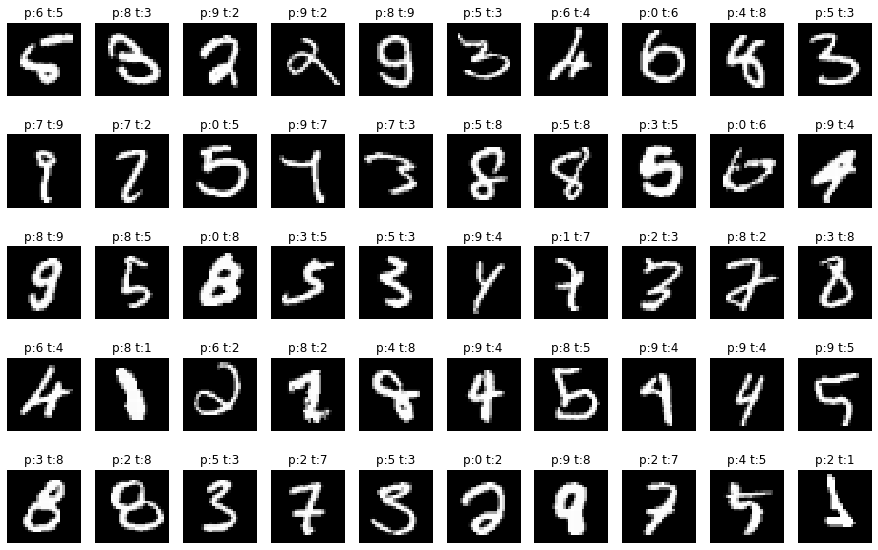

In [105]:
from matplotlib import pyplot as plt
err=0
sum=[0 for i in range(10)]
ecnt=[0 for i in range(10)]
Y=torch.argmax(predict(test_image),dim=1)
for i in range(Y.shape[0]):
    sum[test_label[i]]+=1
    if(Y[i]!=test_label[i]):
        err+=1
        ecnt[test_label[i]]+=1
        if err<=50:
            plt.subplots_adjust(left=1, bottom=None, right=3, top=2, wspace=None, hspace=None)
            plt.subplot(5, 10, err)
            plt.axis('off')
            img=np.array(list(test_image[i].cpu())).reshape(28,-1)
            plt.imshow(img, cmap='gray',interpolation='nearest')
            plt.title("p:%d t:%d"% (Y[i],test_label[i]))
for i in range(len(sum)):
    print("%d:%d/%d=%.10lf"%(i,ecnt[i],sum[i],ecnt[i]/sum[i]))